In [2]:
import sys
import os
import json
import argparse
from typing import Any, Dict, List, Tuple
import torch

from holdem.utils import Logger, set_global_seed
from holdem.environment import Env, num_actions, state_shape
from holdem.environment.game import HoldemGameState

from benchmark.agents import create_agent



In [3]:
def get_config(args)->Dict[str, Any]:
    print(f"Loading config from {args.config}")
    with open(args.config, "r") as f:
        config = json.load(f)
    config_dump_path = os.path.join(args.logdir, args.name, "config.json")
    os.makedirs(os.path.dirname(config_dump_path), exist_ok=True)
    with open(config_dump_path, "w") as f:
        json.dump(config, f, indent=4)
    return config

In [4]:
def create_game(config: Dict[str, Any]) -> Tuple[Env, List]:
    agents = [
        create_agent(agent_config["agent"], **agent_config["args"])
        for agent_config in config["agents"]
    ]
    num_players = len(agents)
    seed = config["settings"].get("seed", 3407)
    __env_config: Dict[str, Any] = {"num_players": num_players, "seed": seed}
    set_global_seed(seed=seed)
    env = Env(**__env_config, agents=agents)
    return env, agents


In [5]:
def run_game(config: Dict[str, Any]):

    total_rounds = config["settings"].get("total_rounds", 1000)
    env, agents = create_game(config=config)

    trajectories_list = []
    payoffs_list = []

    for episode in range(total_rounds):
        trajectories, payoffs = env.run(is_training=True)
        trajectories_list.append(trajectories)
        payoffs_list.append(payoffs)
        # print("### Trajectories ###")
        # print(trajectories)
        # print("###    Payoff    ###")
        # print(payoffs)
    return trajectories_list, payoffs_list

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--config",
    type=str,
    default="benchmark/config/game_random+dqn.json",
)
parser.add_argument(
    "--logdir",
    type=str,
    default="experiments",
)
parser.add_argument(
    "--name",
    type=str,
    default="test",
)

args = parser.parse_args(['--config', 'benchmark\\config\\game_random+rulebased.json'])
config = get_config(args=args)

Loading config from benchmark\config\game_random+rulebased.json


In [7]:
trajectories_list, payoffs_list = run_game(config)

KeyboardInterrupt: 

In [44]:
from matplotlib import pyplot as plt
import numpy as np

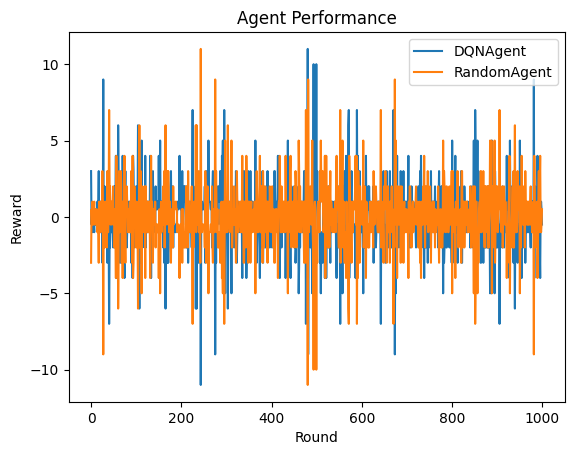

In [46]:
def plot_payoffs(config:Dict[str, Any], payoffs_list:List[List[float]]) -> None:
    payoff_array = np.array(payoffs_list)
    for idx, agent_config in enumerate(config['agents']):
        plt.plot(payoff_array[:,idx], label=agent_config['name'])
    plt.xlabel('Round')
    plt.ylabel('Reward')
    plt.title('Agent Performance')
    plt.legend()
    plt.show()

plot_payoffs(config=config, payoffs_list=payoffs_list)